In [22]:
import dolfinx as dlx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from eikonax import derivator, preprocessing, solver, tensorfield
from ls_prior import builder
from mpi4py import MPI

from cardiac_electrophysiology import fibertensor, pts_map
from cardiac_electrophysiology.ls_bip import components, posterior
from cardiac_electrophysiology.utils import data_processing as dp

sns.set_theme(style="ticks")

In [23]:
mesh = dlx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([1, 1])],
    [20, 20],
    dlx.mesh.CellType.triangle,
)
vertices = mesh.geometry.x[:, :2]
simplices = mesh.geometry.dofmap
num_simplices = simplices.shape[0]
simplex_to_vertex_matrix = dp.assemble_simplex_to_vertex_interpolation_matrix(simplices)
vertex_to_simplex_matrix = dp.assemble_vertex_to_simplex_interpolation_matrix(simplices)

num_observations = 100
noise_var = 1e-4
mean_angle_vector = np.full(simplices.shape[0], 3 / 8 * np.pi)
mean_angle_vector = simplex_to_vertex_matrix @ mean_angle_vector
mean_parameter_vector = np.arctanh(np.cos(mean_angle_vector + np.pi / 2))
ground_truth_parameter_vector = mean_parameter_vector / 3
first_basis_vector = np.repeat([[1, 0]], num_simplices, axis=0)
second_basis_vector = np.repeat([[0, 1]], num_simplices, axis=0)
longitudinal_velocity_vector = np.full(num_simplices, 3)
transversal_velocity_vector = np.full(num_simplices, 1)
initial_site_ind = np.where((vertices[:, 0] == 0) & (vertices[:, 1] == 0))[0][0]

In [24]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_parameter_vector,
    kappa=50,
    tau=0.01,
    seed=0,
)
fiber_tensor_settings = fibertensor.FiberTensorSettings(
    dimension=2,
    mean_angle_vector=mean_angle_vector,
    basis_vectors_one=first_basis_vector,
    basis_vectors_two=second_basis_vector,
    longitudinal_velocities=longitudinal_velocity_vector,
    transversal_velocities=transversal_velocity_vector,
)
eikonax_solver_settings = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    max_value=1000,
    loop_type="jitted_while",
    use_soft_update=True,
    softminmax_order=20,
    softminmax_cutoff=0.01,
)
eikonax_derivator_settings = derivator.PartialDerivatorData(
    use_soft_update=True,
    softminmax_order=20,
    softminmax_cutoff=0.01,
)

In [25]:
prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

fiber_tensor = fibertensor.FiberTensor(fiber_tensor_settings)
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field_object = tensorfield.TensorField(
    num_simplices=num_simplices,
    vector_to_simplices_map=tensor_field_mapping,
    simplex_tensor=fiber_tensor,
)

initial_sites = preprocessing.InitialSites(inds=(initial_site_ind,), values=(0,))
mesh_data = preprocessing.MeshData(mesh.geometry.x[:, :2], mesh.geometry.dofmap)
eikonax_solver = solver.Solver(mesh_data, eikonax_solver_settings, initial_sites)
eikonax_derivator = derivator.PartialDerivator(mesh_data, eikonax_derivator_settings, initial_sites)

eikonal_pts_map = pts_map.EikonalPTSMap(
    eikonax_solver,
    eikonax_derivator,
    tensor_field_object,
    vertex_to_simplex_matrix,
    simplex_to_vertex_matrix,
)

In [26]:
prior_mean_solution = eikonal_pts_map.evaluate_forward(mean_parameter_vector)
ground_truth_solution = eikonal_pts_map.evaluate_forward(ground_truth_parameter_vector)

rng = np.random.default_rng(seed=42)
noise = rng.normal(loc=0.0, scale=np.sqrt(noise_var), size=vertices.shape[0])
noisy_solution = ground_truth_solution + noise
observation_inds = rng.integers(low=0, high=vertices.shape[0], size=num_observations)
observations = noisy_solution[observation_inds]

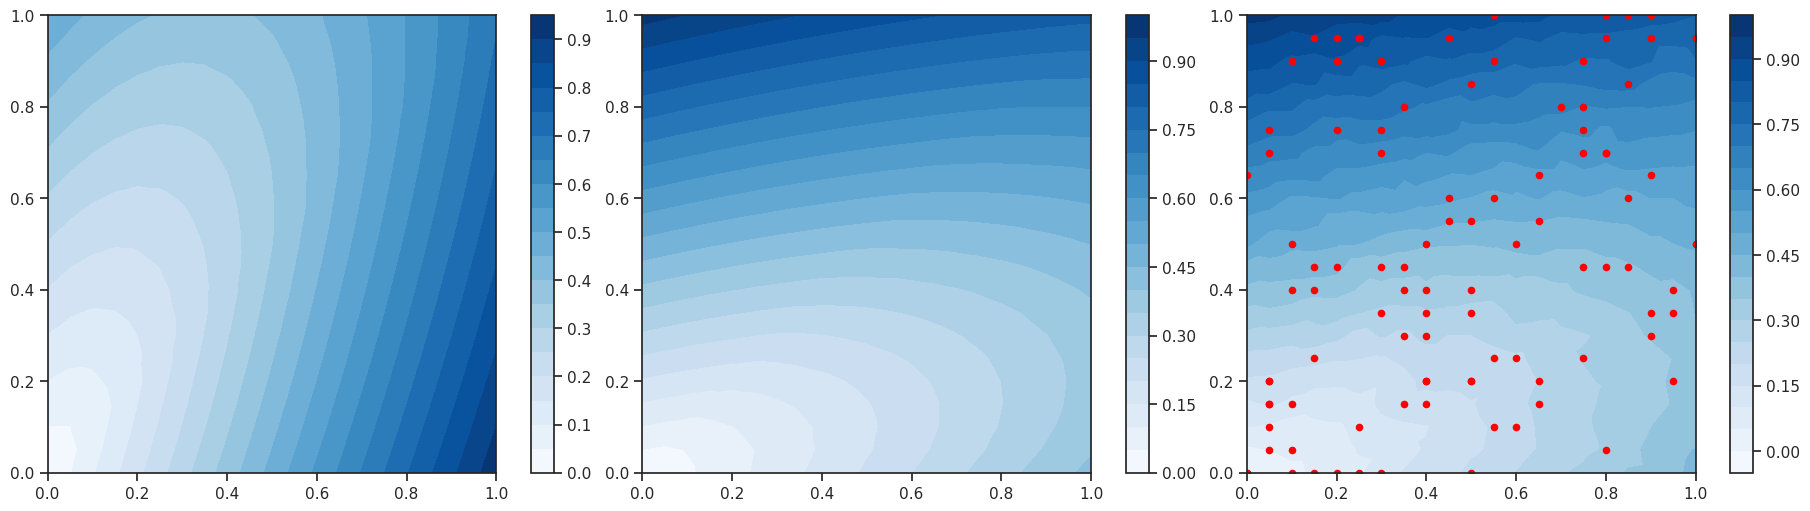

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), layout="constrained")
contour_plot = axs[0].tricontourf(
    vertices[:, 0], vertices[:, 1], prior_mean_solution, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[0])
contour_plot = axs[1].tricontourf(
    vertices[:, 0], vertices[:, 1], ground_truth_solution, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[1])
contour_plot = axs[2].tricontourf(
    vertices[:, 0], vertices[:, 1], noisy_solution, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[2])
axs[2].scatter(
    vertices[observation_inds, 0],
    vertices[observation_inds, 1],
    c="red",
    s=20,
)


In [30]:
precision_values = np.full(num_observations, 1 / noise_var)
observation_matrix = components.assemble_vertex_observation_matrix(
    vertices.shape[0], observation_inds
)
noise_precision_matrix = components.assemble_diagonal_precision_matrix(precision_values)

log_likelihood = components.GaussianLogLikelihood(
    observations, observation_matrix, noise_precision_matrix
)
log_posterior = posterior.LogPosterior(log_likelihood, eikonal_pts_map, bilaplace_prior)

In [31]:
cost = log_posterior.evaluate_cost(ground_truth_parameter_vector)
gradient = log_posterior.evaluate_gradient(ground_truth_parameter_vector)